### This notebook is for explaination of the rationale behind certain model decisions and error analysis.

### 1. What is learnt from the EDA

1. Tiny ImageNet is perfectly balanced with 500 images per class for training and 50 per class for validation. Accuracy is a reliable metric.

2. The model is at risk to "overfitting" there is not a lot of images per class.

3. Classes are not random; they belong to broader semantic groups (e.g., several types of dogs, several types of birds, several types of vehicles).

### 2. Modeling approaches

#### 2.0 Data Augmentation

Strategy for Fighting Overfitting: Data Augmentation
Since our EDA showed that 500 images per class is a very small sample for a 200-class problem, the model is highly prone to "memorizing" the training set. To fix this, I designed three levels of data augmentation to see how much "noise" the model can handle while still learning useful features.

1. Baseline (The Control Group)
What it is: Only basic conversion to Tensor and Normalization. No flips, no crops, no rotations.

2. Standard (Geometric Invariance)
What it is: Added RandomHorizontalFlip and RandomRotation(15).


3. Heavy (Feature Robustness & Occlusion)
What it is: Added RandomResizedCrop, ColorJitter, and RandomErasing.

#### 2.1 Experimented Architecture

1. **AlexNet inspired architecture** - A bit outdated but good as a baseline for what modern NNs should be able to achieve. Have to be modify a bit to deals with the images size.  

2. **ResNet inspired architecture** - Modern NNs which should be a good architecture for general image classification tasks.  

3. **Hierarchical ResNet architecture** - By exploiting the hierarchical nature of data, this architecture (a few linear layers on top of ResNet) should be able to learn both what constitute a given class e.g., Canine, Feline and Coarser group e,g,. mammalia at the same time, additionally the NNs should make the features space after Gradient descent of the same coarse group closer together to help with task 2 Image search.  
In short the architecture learn a distance-based feature space, in addition to build a decision boundry between classes, cluster sub-classes together. The optimizer there fore optimized the the following;  
**Cross-Entropy Loss (The Classifier)**: Drives the three heads ($L_{Coarse}, L_{Mid}, L_{Fine}$) to separate the classes.  
**Center Loss (The Aggregator)**: It minimizes the distance between each sample and its class center in the 512-D feature space.   
**Total Loss Equation**: $$L_{total} = \lambda_0 L_{center} + \lambda_1 L_{coarse} + \lambda_2 L_{mid} + \lambda_3 L_{fine}$$

Based on:
Wen et al., 2016 (https://kpzhang93.github.io/papers/eccv2016.pdf)

#### 2.2 Augmentation and Models Comparison

Best Validation Loss:
AlexNet Base: 4.973932313919067
AlexNet Standard: 5.063638353347779
AlexNet Heavy: 4.978162837028504
ResNet Base: 4.109376859664917
ResNet Standard: 4.263938951492309
ResNet Heavy: 4.276420736312867
Best Validation Accuracies:
AlexNet Base: 14.76%
AlexNet Standard: 11.28%
AlexNet Heavy: 17.75%
ResNet Base: 48.55%
ResNet Standard: 50.69%
ResNet Heavy: 51.81%


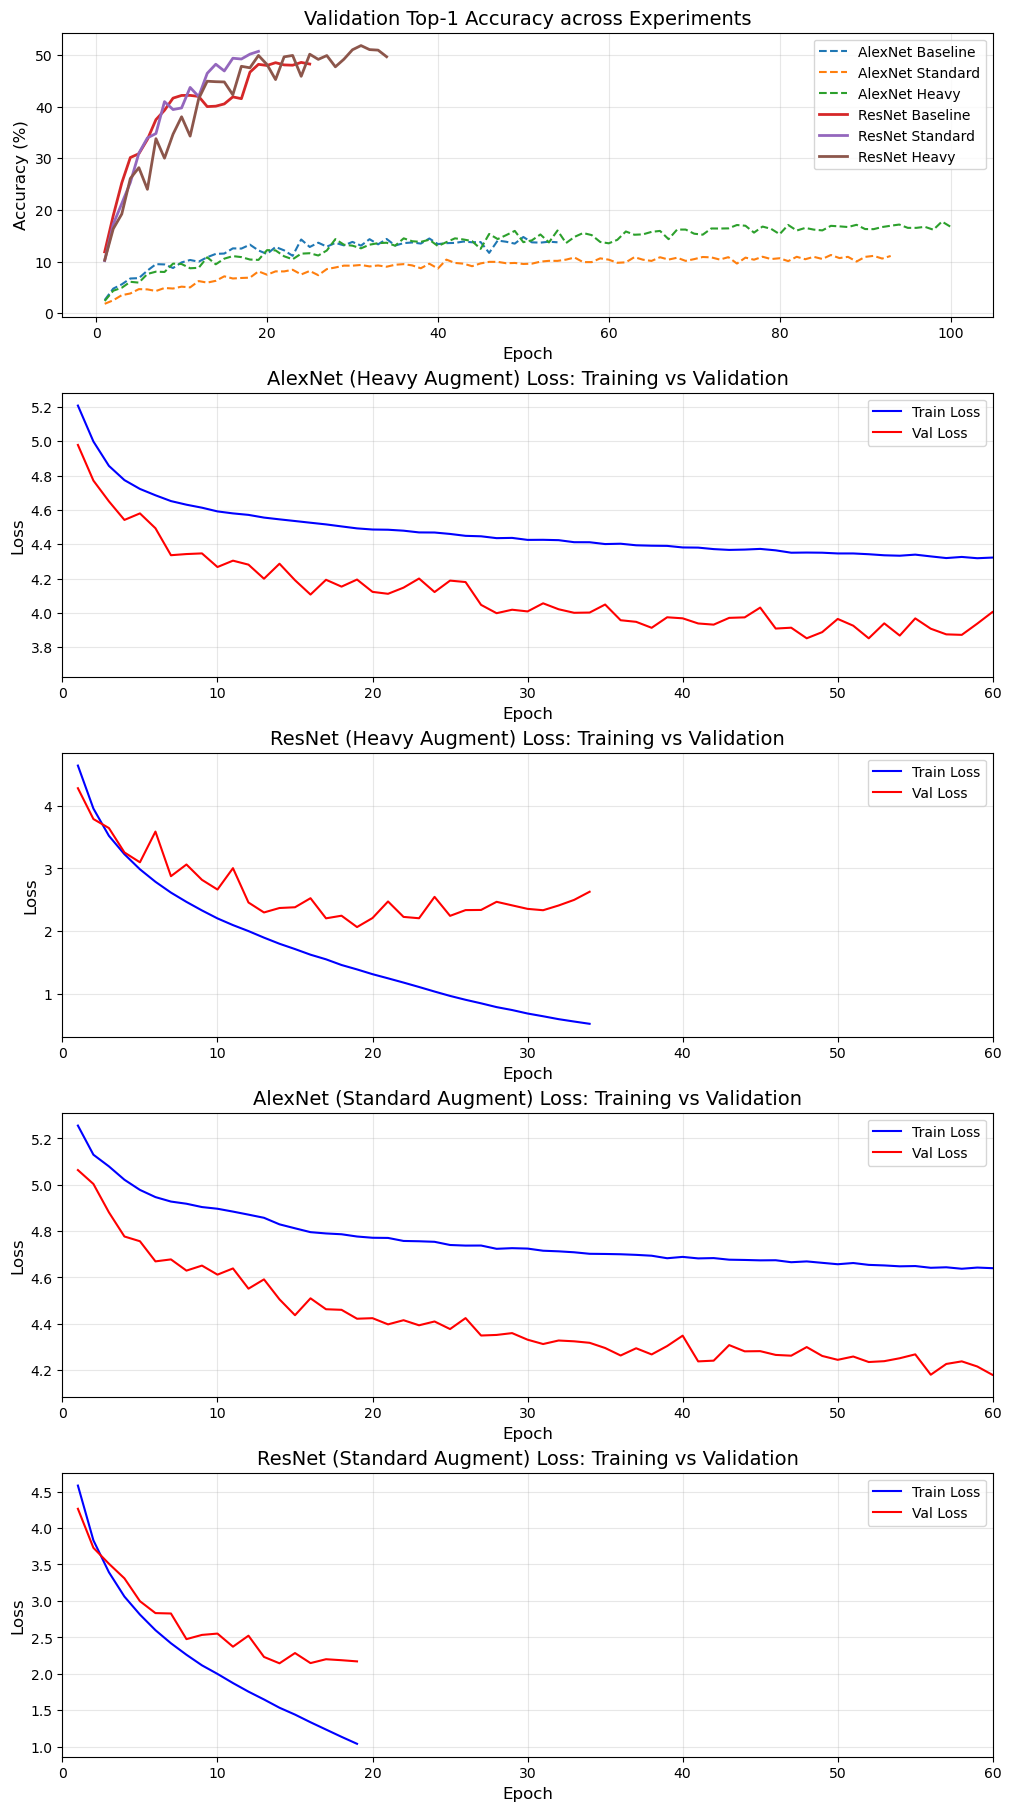

In [1]:
from viz import alex_res_viz

alex_res_viz()

Here we can see that according to validation loss the best model is standard augmentation resnet, but according to accuracy is heavy resnet. There are an argument for both approach but based on computation, **standard augmentation resnet will be assume to be the best model.**  
Now a better approach would be using cross-validation so SE can be computed, but with the interest of time and computation validation set be be use.

1. Now the ResNet substaincially outperform AlexNet inspired one. The reason might be that Residual block allows the NNs to go deeper thus learn a deeper connection. Deeper network (8 v 18) should results in a better discriminator.

2. In contrast augmentation does not affect the data that much in this case standard augmentation, does not added to the computation cost with the best loss will be chosen.

3. It can be seen that model with heavy augmentation, the training and validation loss decouple latter than the standard one, this suggest that augmentation help mitigates "overfitting"*. Residule connection of ResNet has similar effect of mitigated overfitting althrough much more substaintially. 

#### 2.3 Hierarchical Network

##### First let's look at the performance

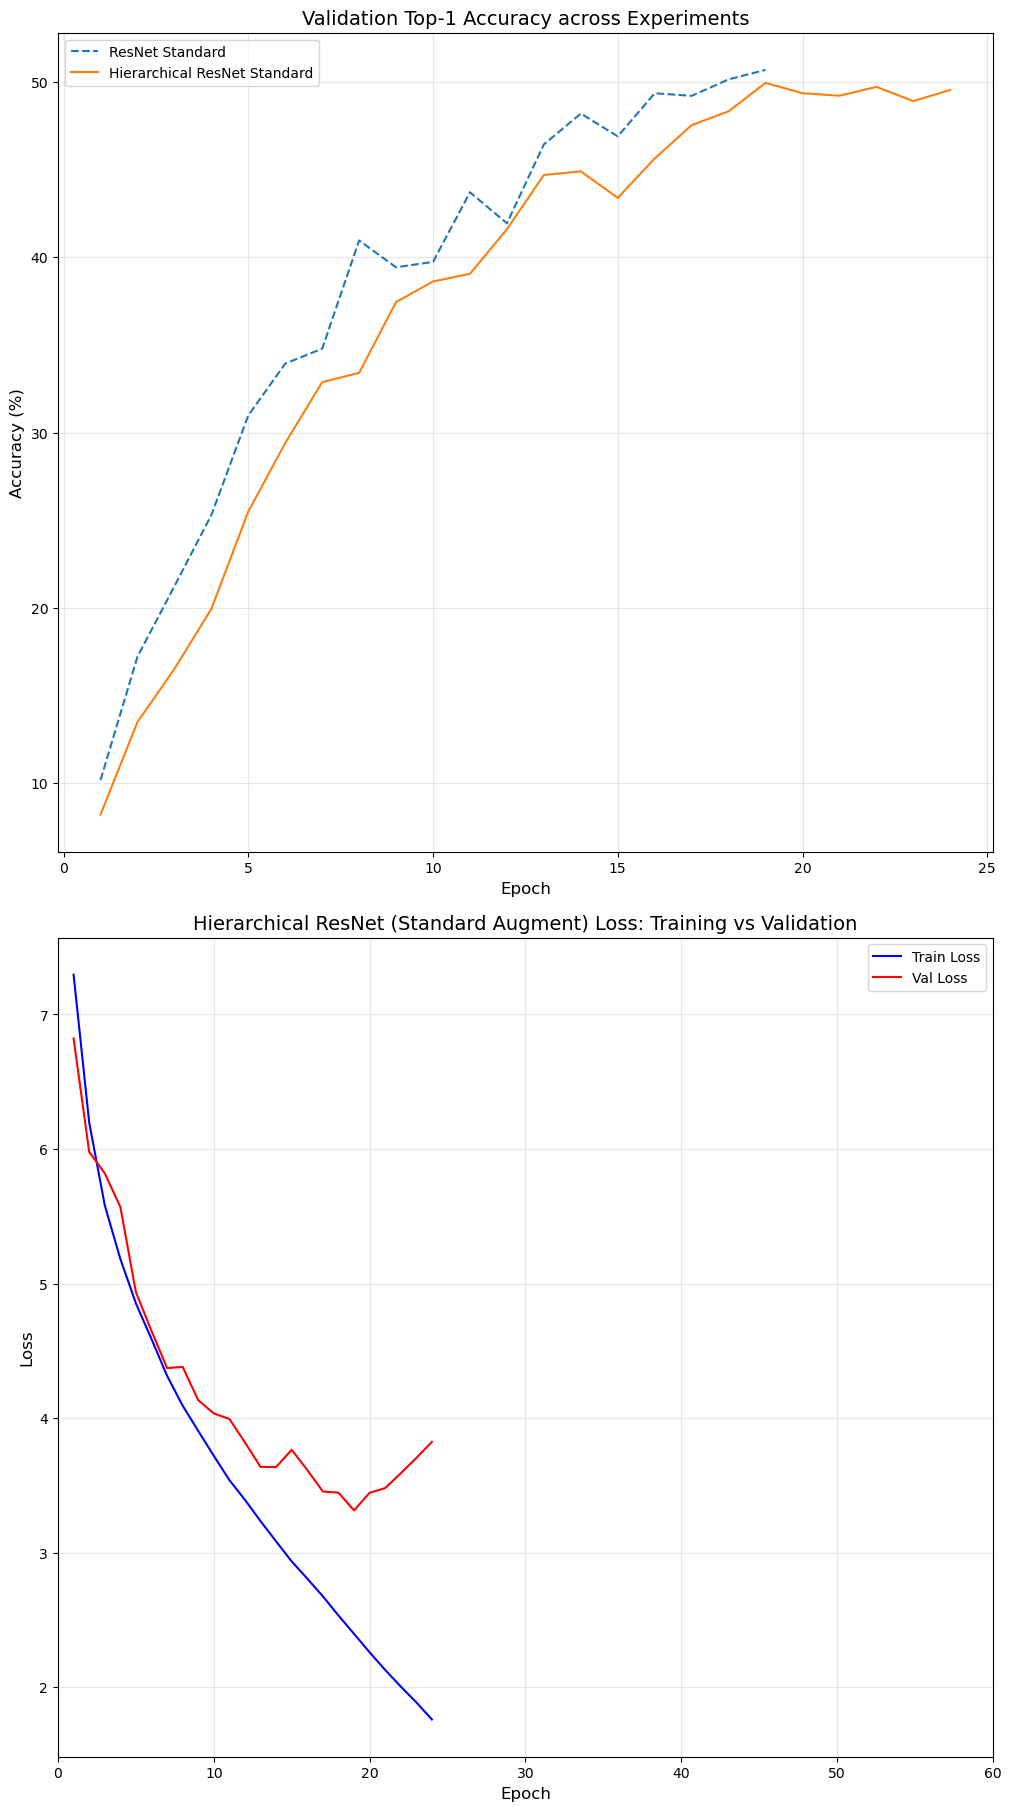

In [2]:
from viz import heirarchy_viz

heirarchy_viz()

The performance of the two models are roughly equal the losses are as follow;  
ResNet = 2.1441 and Heirarchical = 2.1646 
and the acc@1 and acc@h;  
ResNet = 48.2% / 74.87% and Heirarchical = 49.95% / 75.78%

Heirarchical coarse class acc@1 = Coarse: 85.68% | Mid: 72.12%

Without kfold, we can not for certain knows whether the performance differentare significant or not. But I would say that the two performance are roughly equal.

The advantage of Heirarchical model is that the feature space of similar super-class of images should be close together this can be view by looking at the feature space's manifold.

/home/punny/anaconda3/envs/tiny_vision/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Val Loader initialized with 10000 images.


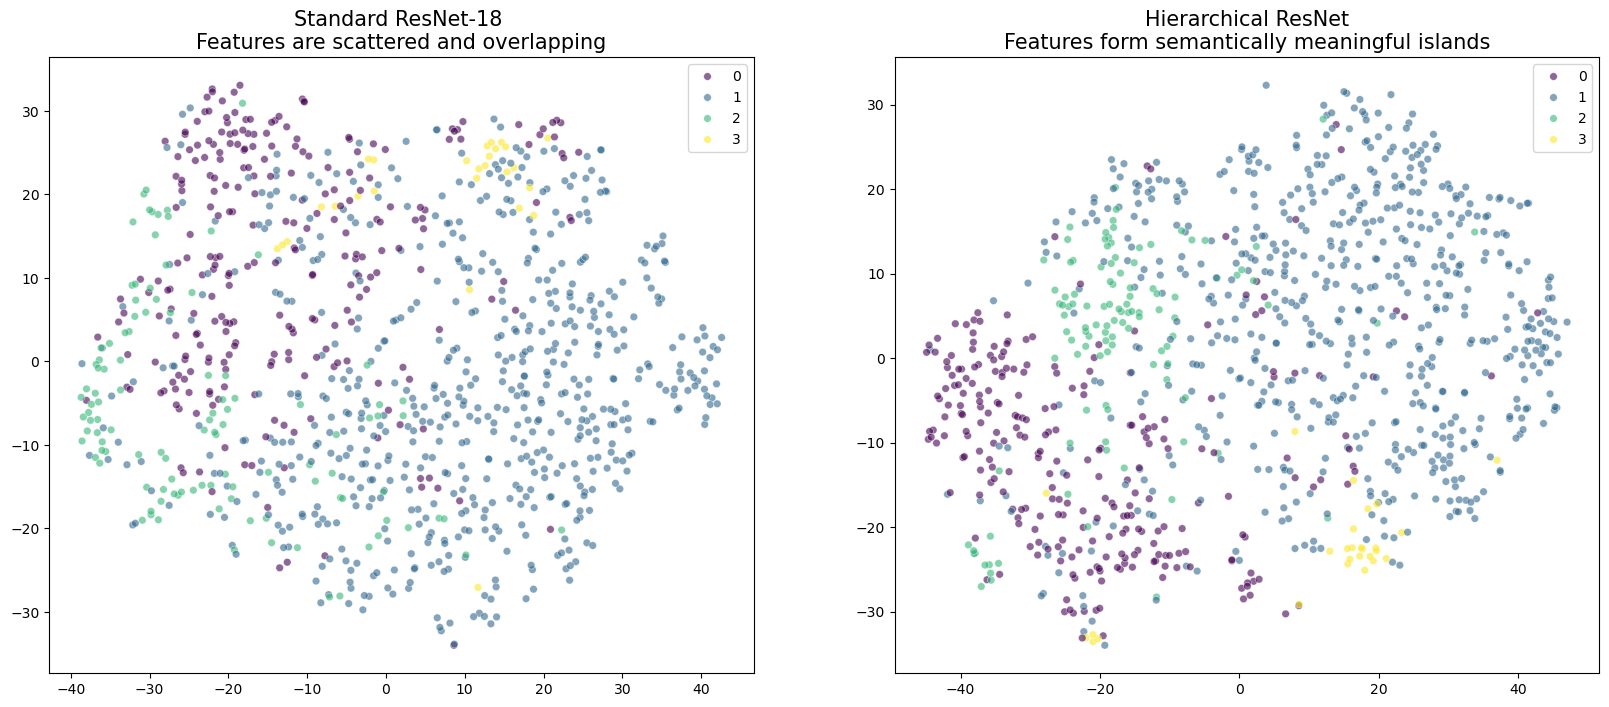

In [3]:
import os
import torch

from viz import plot_tsne_comparison
from utils.helper import prepare_dataloaders
from models.res_net import TinyResNet
from models.hierarchy_resnet import HierarchicalResNet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

n_coarse = 4
n_mid = 13
n_fine = 200
_, val_loader, test_loader, hierarchy_counts = prepare_dataloaders(
    batch_size=64, 
    aug_level="standard", 
    use_hierarchy=True
)

print(f"Val Loader initialized with {len(val_loader.dataset)} images.")
# --- Load Standard Model ---
model_std = TinyResNet(num_classes=200).to(device)
path_std = "best_model_standard_TinyResNet.pth"
model_std.load_state_dict(torch.load(path_std, map_location=device))
model_std.eval()

# --- Load Hierarchical Model ---
# Ensure n_coarse, n_mid, n_fine are defined from your hierarchy counts
model_hier = HierarchicalResNet(num_l1=n_coarse, num_l2=n_mid, num_l3=n_fine).to(device)
path_hier = "best_model_standard_HierarchicalResNet.pth"
model_hier.load_state_dict(torch.load(path_hier, map_location=device))
model_hier.eval()
plot_tsne_comparison(model_std, model_hier, val_loader, device)

* Coarse Classes are the following:
1. Animal
2. Artifact
3. Food
4. Nature

We can see that Heirarchical model's manifold are clustered together more, this will be advantageous for the next task. But for just image classification task *Resnet standard model is the best model, in the basis of its being a simpler model.

#### 2.4 Generalization Ability

Now let's look at the model performance on the testset

In [4]:
from utils.helper import evaluate_final
std_acc1, std_acc5, std_prec = evaluate_final(model_std, test_loader, device, is_hierarchical=False)
print(f"Standard ResNet   | Top-1: {std_acc1:.2f}% | Top-5: {std_acc5:.2f}% | Precision: {std_prec:.2f}%")

# Test Hierarchical Model
hier_acc1, hier_acc5, hier_prec = evaluate_final(model_hier, test_loader, device, is_hierarchical=True)
print(f"Hierarchical Model| Top-1: {hier_acc1:.2f}% | Top-5: {hier_acc5:.2f}% | Precision: {hier_prec:.2f}%")

Standard ResNet   | Top-1: 46.29% | Top-5: 73.55% | Precision: 51.10%
Hierarchical Model| Top-1: 50.52% | Top-5: 75.81% | Precision: 52.77%


In [5]:
from utils.helper import get_class_performance, print_top_bottom

std_perf = get_class_performance(model_std, test_loader, device, is_hierarchical=False)
hier_perf = get_class_performance(model_hier, test_loader, device, is_hierarchical=True)
print_top_bottom(std_perf, "Standard ResNet-18")
print_top_bottom(hier_perf, "Hierarchical ResNet")


========================= Standard ResNet-18 =========================

TOP 5 BEST CLASSES:
   86.00% | ID: 0   | Name: goldfish
   86.00% | ID: 18  | Name: black stork
   86.00% | ID: 120 | Name: picket fence
   86.00% | ID: 155 | Name: trolleybus
   84.00% | ID: 115 | Name: obelisk

BOTTOM 5 WORST CLASSES:
   10.00% | ID: 80  | Name: CD player
   10.00% | ID: 187 | Name: Chihuahua
    6.00% | ID: 58  | Name: bannister
    6.00% | ID: 122 | Name: plunger
    4.00% | ID: 24  | Name: Labrador retriever

========================= Hierarchical ResNet =========================

TOP 5 BEST CLASSES:
   88.00% | ID: 155 | Name: trolleybus
   84.00% | ID: 39  | Name: monarch
   84.00% | ID: 65  | Name: beacon
   84.00% | ID: 74  | Name: bullet train
   82.00% | ID: 6   | Name: trilobite

BOTTOM 5 WORST CLASSES:
   12.00% | ID: 157 | Name: umbrella
   10.00% | ID: 125 | Name: pop bottle
   10.00% | ID: 164 | Name: wooden spoon
    8.00% | ID: 91  | Name: dumbbell
    8.00% | ID: 122 | Name: pl